In [1]:
import json
import pandas as pd
from pprint import pprint as pp
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import snappy
import fastparquet
import dask
import dask.dataframe as dd
import re
import nltk
#nltk.download('words')
#nltk.download('wordnet')

import logging
logger = logging.getLogger('distributed.worker')
logger.setLevel(logging.ERROR)

Load Data:

In [2]:
data = {}
with open('../resources/papers_subjects.json') as f:
    data = json.load(f)

data.keys()

dict_keys(['papers'])

Create Taxonomy:

In [3]:
def get_paper_subjects(paper):
    subjects = [paper['primary-subject']['id_subject']]
    subjects.extend([s['id_subject'] for s in paper['other-subjects']])
    return subjects

subjects_id_set = set()
c_p = 0

for paper in data['papers']:
    # add primary-subject
    primary_subject = paper['primary-subject']
    subjects_id_set.add((primary_subject['id_subject'], primary_subject['name_subject']))
    # check if the primary-subject is in 'Computer Science'
    if primary_subject['id_subject'].startswith('cs.'):
        c_p += 1
    # add other-subjects
    for other_s in paper['other-subjects']:
        subjects_id_set.add((other_s['id_subject'], other_s['name_subject']))
            
print(c_p, len(subjects_id_set))

30948 133


In [4]:
subjects_id_set

{('astro-ph', 'Astrophysics'),
 ('astro-ph.CO', 'Cosmology and Nongalactic Astrophysics'),
 ('astro-ph.EP', 'Earth and Planetary Astrophysics'),
 ('astro-ph.GA', 'Astrophysics of Galaxies'),
 ('astro-ph.HE', 'High Energy Astrophysical Phenomena'),
 ('astro-ph.IM', 'Instrumentation and Methods for Astrophysics'),
 ('astro-ph.SR', 'Solar and Stellar Astrophysics'),
 ('cond-mat', 'Condensed Matter'),
 ('cond-mat.dis-nn', 'Disordered Systems and Neural Networks'),
 ('cond-mat.mes-hall', 'Mesoscale and Nanoscale Physics'),
 ('cond-mat.mtrl-sci', 'Materials Science'),
 ('cond-mat.quant-gas', 'Quantum Gases'),
 ('cond-mat.soft', 'Soft Condensed Matter'),
 ('cond-mat.stat-mech', 'Statistical Mechanics'),
 ('cond-mat.str-el', 'Strongly Correlated Electrons'),
 ('cond-mat.supr-con', 'Superconductivity'),
 ('cs.AI', 'Artificial Intelligence'),
 ('cs.AR', 'Hardware Architecture'),
 ('cs.CC', 'Computational Complexity'),
 ('cs.CE', 'Computational Engineering, Finance, and Science'),
 ('cs.CG', 'Com

Taxonomy: https://arxiv.org

- https://arxiv.org/archive/cs
- https://arxiv.org/archive/astro-ph
- https://arxiv.org/archive/cond-mat
- https://arxiv.org/archive/econ
- https://arxiv.org/archive/eess
- https://arxiv.org/archive/hep-ex
- https://arxiv.org/archive/hep-ph
- https://arxiv.org/archive/hep-th
- https://arxiv.org/archive/math-ph
- https://arxiv.org/archive/math
- https://arxiv.org/archive/nlin
- https://arxiv.org/archive/nucl-ex
- https://arxiv.org/archive/nucl-th
- https://arxiv.org/archive/physics
- https://arxiv.org/archive/q-bio
- https://arxiv.org/archive/q-fin
- https://arxiv.org/archive/quant-ph
- https://arxiv.org/archive/stat

Create DataSet:

In [5]:
%%time
from sklearn.preprocessing import OneHotEncoder
def get_encoder(subjects):
    enc = OneHotEncoder().fit(np.array(sorted([s[0] for s in subjects])).reshape(-1, 1))
    #print(enc.categories_)
    return enc

def get_paper_subjects(paper):
    subjects = [paper['primary-subject']['id_subject']]
    subjects.extend([s['id_subject'] for s in paper['other-subjects']])
    return subjects

def transform_paper_subjects(enc, paper_subjects):
    return sum(enc.transform(np.array(paper_subjects).reshape(-1, 1)).toarray()) #.todense()


data_df = []
columns_df = ['paper_id', 'primary-subject']
columns_df.extend(sorted([c[0] for c in subjects_id_set]))

enc = get_encoder(subjects_id_set)

for paper in data['papers']:
    #if paper['primary-subject']['id_subject'].startswith('cs.'):
    row_df = [paper['id'], paper['primary-subject']['id_subject']]
    paper_subjects = get_paper_subjects(paper)
    row_df.extend(transform_paper_subjects(enc, paper_subjects))
    data_df.append(row_df)

df = pd.DataFrame(data=data_df, columns=columns_df, dtype=np.uint8)
df

CPU times: user 13.2 s, sys: 218 ms, total: 13.4 s
Wall time: 13.5 s


,paper_id,primary-subject,astro-ph,astro-ph.CO,astro-ph.EP,astro-ph.GA,astro-ph.HE,astro-ph.IM,astro-ph.SR,cond-mat,...,q-fin.PM,q-fin.RM,q-fin.ST,q-fin.TR,quant-ph,stat.AP,stat.CO,stat.ME,stat.ML,stat.OT
0,41513,cs.CV,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,41587,stat.ML,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,61821,cs.LG,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,61822,cs.LG,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,61823,cs.LG,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37363,101219,cs.LG,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
37364,101220,cs.LG,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
37365,101221,cs.CV,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
37366,101222,cs.LG,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [6]:
# save dataset
dataset_path = "../resources/papers-subjects-dataset.pkl"
df.to_pickle(dataset_path, protocol=4)

In [6]:
def get_primary_subject_by_paper_id(paper_id):
    paper_row = df.loc[df.paper_id == paper_id]
    return paper_row['primary-subject'].to_numpy()[0]

def get_all_subjects_by_paper_id(paper_id):
    paper_row = df.loc[df.paper_id == paper_id].squeeze()
    return paper_row.index[paper_row == 1].to_list()

#print(get_primary_subject_by_paper_id('61822'))
#print(get_all_subjects_by_paper_id('61822'))

In [7]:
#%%time
## check:
#count = 0
#for paper in data['papers']:
#    #if paper['primary-subject']['id_subject'].startswith('cs.'):
#    if paper['primary-subject']['id_subject'] != get_primary_subject_by_paper_id(paper['id']):
#        print("Error primary-subject for %s." % paper['id'])
#    else:
#        if sorted(get_paper_subjects(paper)) != get_all_subjects_by_paper_id(paper['id']):
#            print("Error all-subject for %s." % paper['id'])
#        else:
#            count += 1
#print(count)

37368
CPU times: user 4min 10s, sys: 1.09 s, total: 4min 11s
Wall time: 4min 14s


In [8]:
#BYTES_TO_MB_DIV = 0.000001
#def print_memory_usage_of_data_frame(df):
#    mem = round(df.memory_usage().sum() * BYTES_TO_MB_DIV, 3) 
#    print("Memory usage is " + str(mem) + " MB")
#
#print_memory_usage_of_data_frame(df)

Memory usage is 5.568 MB


Visualize paper-subjects:

In [9]:
subjects_counts = []
for s in subjects_id_set:
    subjects_counts.append((s[0],df[s[0]].sum()))

df_stats = pd.DataFrame(subjects_counts, columns=['subject', 'number_of_papers'])
df_stats

,subject,number_of_papers
0,q-fin.ST,28
1,math.ST,377
2,math-ph,5
3,cs.LO,70
4,q-bio.CB,1
...,...,...
128,econ.GN,4
129,astro-ph.HE,1
130,cs.OH,1
131,cs.CR,463


Text(0.5, 0, 'subject')

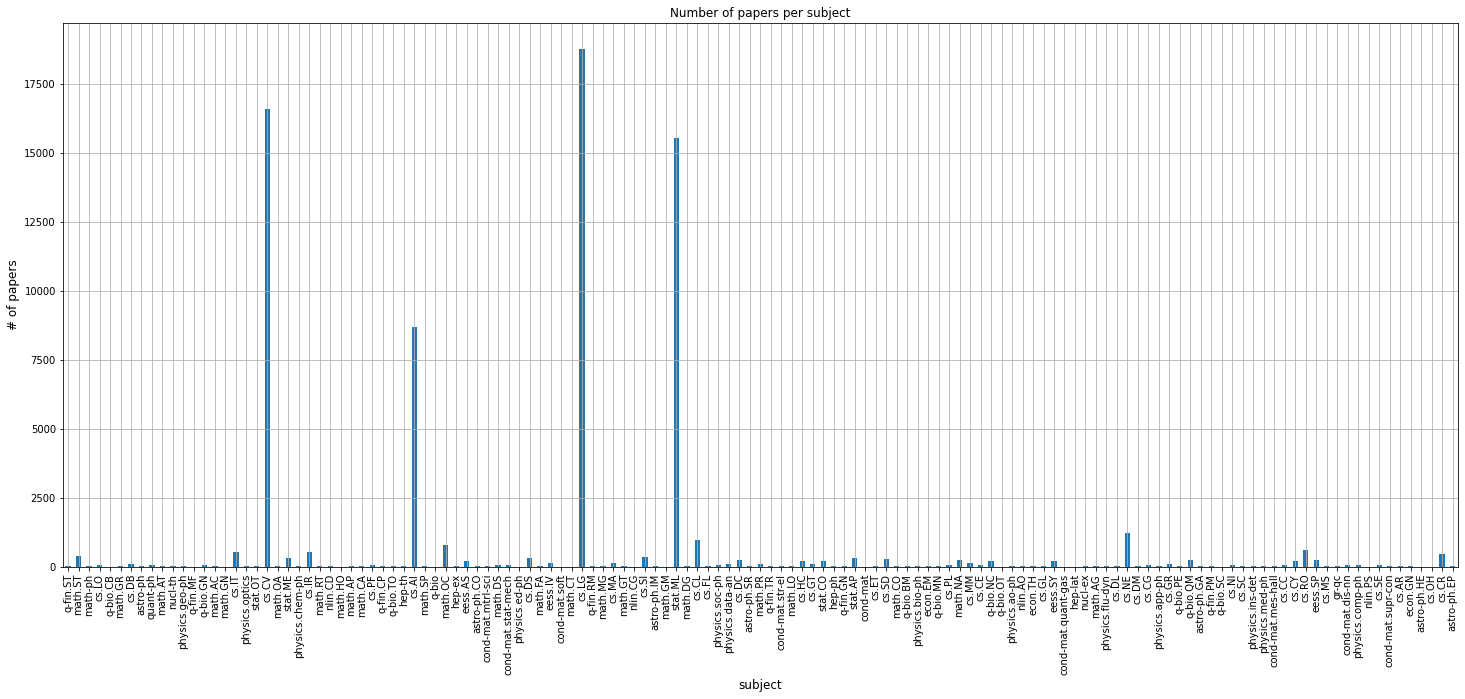

In [10]:
df_stats.plot(x='subject', y='number_of_papers', kind='bar', legend=False, grid=True, figsize=(25, 10))
plt.title("Number of papers per subject")
plt.ylabel('# of papers', fontsize=12)
plt.xlabel('subject', fontsize=12)

<AxesSubplot:>

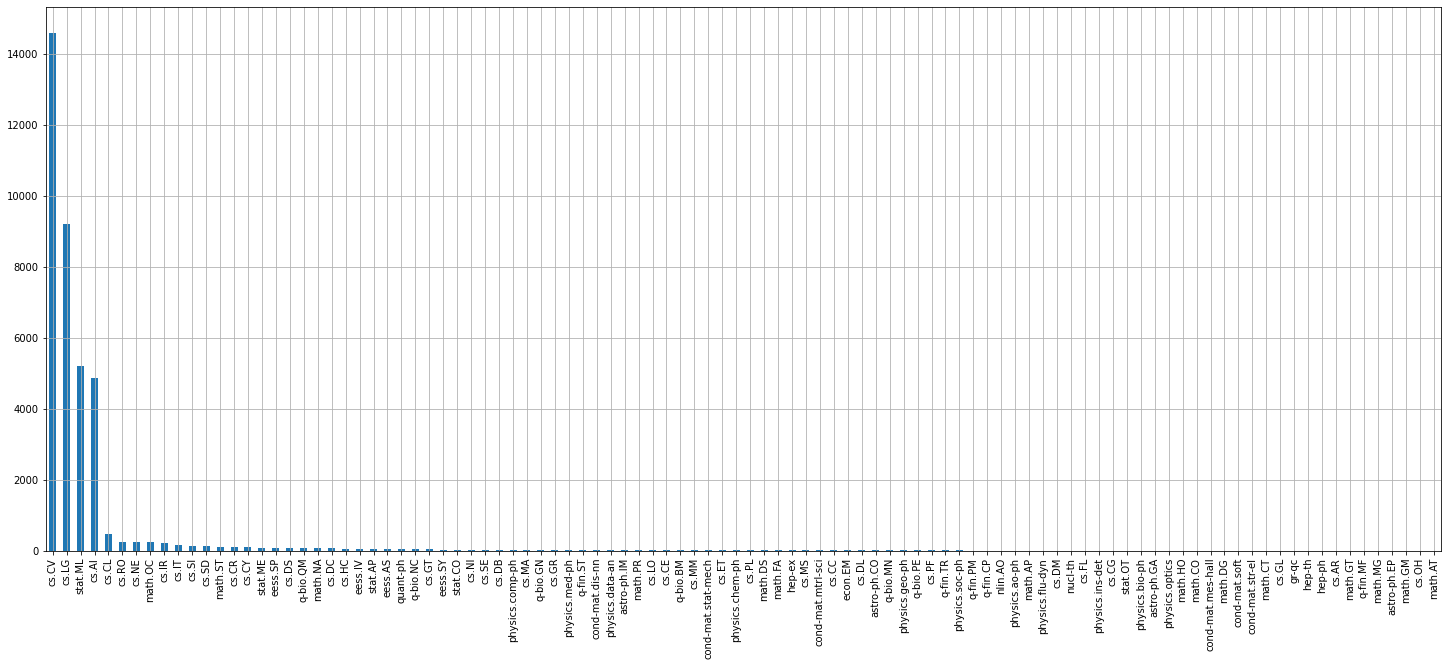

In [11]:
df['primary-subject'].value_counts().plot(kind='bar', grid=True, figsize=(25, 10))

Load papers text:

In [19]:
%%time
data_dir = "../../data/papers"
parquets_dir = "../resources/papers-parquets"
df_text = pd.DataFrame(columns=["paper_id", "text"])
count_papers = 0
count_parquets =0
for paper_id in list(df['paper_id']):
    # extract entire text from txt
    paper_dir = os.path.join(data_dir, 'paper_'+paper_id)
    if os.path.isdir(paper_dir):
        paper_txt = os.path.join(paper_dir, 'paper_'+paper_id+'.txt')
        if os.path.isfile(paper_txt):
            text = ''
            with open(paper_txt, 'r', encoding='utf-8') as f:
                text = f.read()
            df_text = df_text.append({'paper_id': paper_id, 'text': text}, ignore_index=True)
            count_papers += 1
        else:
            print("Error: '%s' not found." % paper_txt)
    else:
        print("Error: '%s' not found." % paper_dir)
    # save in parquet
    if count_papers == 2000: # 2 2000
        parquet_path = os.path.join(parquets_dir, 'papers-'+'{:0>2d}'.format(count_parquets)+'.snap.parquet')
        fastparquet.write(parquet_path, df_text, compression='snappy')
        print(parquet_path)
        count_parquets += 1
        count_papers = 0
        df_text = pd.DataFrame(columns=["paper_id", "text"])
# save in last parquet
if count_papers > 0:
    parquet_path = os.path.join(parquets_dir, 'papers-'+'{:0>2d}'.format(count_parquets)+'.snap.parquet')
    fastparquet.write(parquet_path, df_text, compression='snappy')
    print(parquet_path)
    count_parquets += 1

../resources/papers-parquets/papers-00.snap.parquet
../resources/papers-parquets/papers-01.snap.parquet
../resources/papers-parquets/papers-02.snap.parquet
../resources/papers-parquets/papers-03.snap.parquet
../resources/papers-parquets/papers-04.snap.parquet
../resources/papers-parquets/papers-05.snap.parquet
../resources/papers-parquets/papers-06.snap.parquet
../resources/papers-parquets/papers-07.snap.parquet
../resources/papers-parquets/papers-08.snap.parquet
../resources/papers-parquets/papers-09.snap.parquet
../resources/papers-parquets/papers-10.snap.parquet
../resources/papers-parquets/papers-11.snap.parquet
../resources/papers-parquets/papers-12.snap.parquet
../resources/papers-parquets/papers-13.snap.parquet
../resources/papers-parquets/papers-14.snap.parquet
../resources/papers-parquets/papers-15.snap.parquet
../resources/papers-parquets/papers-16.snap.parquet
../resources/papers-parquets/papers-17.snap.parquet
../resources/papers-parquets/papers-18.snap.parquet
CPU times: u

Clean papers text:

In [13]:
from dask.distributed import Client
client = Client(n_workers=1, threads_per_worker=4, processes=False, memory_limit='6GB')
client

Client Scheduler: inproc://192.168.1.21/2291/1 Dashboard: http://192.168.1.21:8787/status,Cluster Workers: 1 Cores: 4 Memory: 6.00 GB


In [20]:
%%time
parquets_dir = "../resources/papers-parquets"
ddf = dd.read_parquet(parquets_dir, index=False, engine='fastparquet')
ddf.compute()

CPU times: user 6.94 s, sys: 4.8 s, total: 11.7 s
Wall time: 13.8 s


,paper_id,text
0,41513,Learning to Poke by Poking: Experiential Learn...
1,41587,Sample Complexity of Episodic Fixed-Horizon\nR...
2,61821,Adaptive learning rates and parallelization fo...
3,61822,Barnes-Hut-SNE\nLaurens van der Maaten\nPatter...
4,61823,Block Coordinate Descent for Sparse NMF\nVamsi...
...,...,...
1363,101219,arXiv:1809.02499v3\n[cs.LG]\n22\nNov\n2018\nMi...
1364,101220,Latent Fisher Discriminant Analysis\nGang Chen...
1365,101221,"1\nStochastic Graphlet Embedding\nAnjan Dutta,..."
1366,101222,A Bayesian Approach to Learning Bayesian Netwo...


In [21]:
# merge lines and text cleaning
def merge_lines(text):
    lines = [l.strip() for l in text.strip().split('\n')]
    merged_lines = ""
    for line in lines:
        if len(line)>0:
            if line[-1]=='-':
                merged_lines = merged_lines+' '+line[:-1]
            else:
                merged_lines = merged_lines+' '+line
    return merged_lines.strip()

def initial_text_cleaning(text):
    text = text.lower()                                             # transform to lowercase
    text = re.sub(r'\n', '', text)                                  # remove \n
    text = re.sub(r'(\(|\[|\{)[^(\)|\]|\})]*(\)|\]|\})', '', text)  # remove everything in parentheses
    text = re.sub(r'http(s)?:\/\/\S+', '', text)                    # remove url
    text = re.sub(r'[^a-z\s]', '', text)  #[^\w\s]                  # remove everything that is not a word (therefore also numbers and punctuation)
    text = re.sub(r'\b\w{1,2}\b', '', text)                         # remove all single and double letters
    text = re.sub(r'\b(h|i|j|k|x|y)+\b', '', text)                  # remove some common letters used in formules 
    text = re.sub(r'\s{2,}', ' ', text).strip()                     # reformat spaces
    return text


# cleaning text of stop words
from nltk.corpus import stopwords
def remove_stopwords(text, stopwords):
    words = text.split()
    return ' '.join([w for w in words if w not in stopwords])

# cleaning text of nonsense words
from nltk.corpus import words
words_dictionary = set(words.words())
def remove_nonsensewords(text):
    words = text.split()
    return ' '.join([w for w in words if w in words_dictionary])


# stemming and lemmatization
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()
def stemming(text):
    words = text.split()
    return ' '.join([porter.stem(w) for w in words])

from nltk.stem.wordnet import WordNetLemmatizer
wordnet = WordNetLemmatizer()
def lemmatization(text):
    words = text.split()
    return ' '.join([wordnet.lemmatize(w) for w in words])

In [22]:
%%time
# merge lines:
ddf['text'] = ddf['text'].apply(merge_lines, meta=(None, 'object'))

# text - cleaning:
ddf['text'] = ddf['text'].apply(initial_text_cleaning, meta=(None, 'object'))

# remove stop-words:
stopwords_file = "../resources/stopwords_list.txt"
stopwords_extended_list = stopwords.words('english')
with open(stopwords_file, 'r') as file:
    stopwords_extended_list.extend([line.replace('\n', '') for line in file.readlines()])
stopwords_extended_list.extend(['table', 'tab', 'figure', 'fig', 'arxiv', 'arxivv'])
stopwords = set(stopwords_extended_list)
ddf['text'] = ddf['text'].apply(lambda x: remove_stopwords(x, stopwords), meta=(None, 'object'))

## stemming and lemmatization:
ddf['text'] = ddf['text'].apply(stemming, meta=(None, 'object'))
#ddf['text'] = ddf['text'].apply(lemmatization, meta=(None, 'object'))

# remove nonsense-words:
#ddf['text'] = ddf['text'].apply(remove_nonsensewords, meta=(None, 'object'))

CPU times: user 35.7 ms, sys: 9.62 ms, total: 45.3 ms
Wall time: 246 ms


In [23]:
%%time
ddf.compute()

distributed.comm.inproc - WARNING - Closing dangling queue in <InProc  local=inproc://192.168.1.21/2291/9 remote=inproc://192.168.1.21/2291/1>


CPU times: user 53min 39s, sys: 1min 26s, total: 55min 5s
Wall time: 55min 18s


,paper_id,text
0,41513,learn poke poke experienti learn intuit physic...
1,41587,sampl complex episod fixedhorizon reinforc lea...
2,61821,adapt learn rate parallel stochast spars nonsm...
3,61822,barneshutsn lauren der maaten pattern recognit...
4,61823,block coordin descent spars nmf vamsi potluru ...
...,...,...
1363,101219,nov mixup local linear outofmanifold regular h...
1364,101220,latent fisher discrimin analysi gang chen depa...
1365,101221,stochast graphlet embed anjan dutta member iee...
1366,101222,bayesian approach learn bayesian network local...


Save text-clean dataset:

In [24]:
%%time
clean_parquets_dir = "../resources/papers-textclean-parquets"
dd.to_parquet(ddf, clean_parquets_dir, engine='fastparquet', compression='snappy')

CPU times: user 53min 30s, sys: 1min 18s, total: 54min 48s
Wall time: 54min 35s
